In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)

In [107]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


In [108]:
print(trades.isnull().sum())
print(sentiment.isnull().sum())

print("Duplicates trades:", trades.duplicated().sum())
print("Duplicates sentiment:", sentiment.duplicated().sum())

trades.drop_duplicates(inplace=True)
sentiment.drop_duplicates(inplace=True)

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicates trades: 0
Duplicates sentiment: 0


In [109]:
# Trading timestamps stored as Unix milliseconds
trades['Timestamp'] = pd.to_numeric(trades['Timestamp'], errors='coerce')

trades['Timestamp'] = pd.to_datetime(
    trades['Timestamp'],
    unit='ms',
    origin='unix'
)

# daily alignment
trades['date'] = trades['Timestamp'].dt.floor('D')

In [110]:
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'])
sentiment['date'] = sentiment['timestamp'].dt.floor('D')

In [111]:
trades = trades.dropna(subset=['date'])
sentiment = sentiment.dropna(subset=['date'])

In [112]:
trades_sorted = trades.sort_values('date')
sentiment_sorted = sentiment.sort_values('date')

df = pd.merge_asof(
    trades_sorted,
    sentiment_sorted[['date','value','classification']],
    on='date',
    direction='backward'
)

df[['date','value','classification']].head()

,date,value,classification
0,2023-03-28,67,Greed
1,2023-03-28,67,Greed
2,2023-03-28,67,Greed
3,2023-11-14,67,Greed
4,2023-11-14,67,Greed


In [113]:
daily_pnl = df.groupby(['Account','date'])['Closed PnL']\
              .sum().reset_index()

daily_pnl.rename(columns={'Closed PnL':'daily_pnl'}, inplace=True)

In [114]:
df['win'] = df['Closed PnL'] > 0

win_rate = df.groupby(['Account','date'])['win']\
             .mean().reset_index()

win_rate.rename(columns={'win':'win_rate'}, inplace=True)

In [115]:
avg_trade = df.groupby(['Account','date'])['Size USD']\
              .mean().reset_index()

avg_trade.rename(columns={'Size USD':'avg_trade_size'}, inplace=True)

In [116]:
trades_day = df.groupby(['Account','date'])\
               .size().reset_index(name='trades_per_day')

In [117]:
df['direction'] = df['Direction'].str.lower()

ls = df.groupby(['Account','date','direction'])\
       .size().unstack(fill_value=0).reset_index()

ls['long_short_ratio'] = (
    ls.get('buy',0) / (ls.get('sell',0) + 1)
)

In [118]:
df['leverage_proxy'] = (
    df['Size USD'].abs() /
    (df['Start Position'].abs() + 1e-6)
)

In [120]:
# create full daily date range covering trades
full_dates = pd.date_range(
    start=sentiment['date'].min(),
    end=trades['date'].max(),
    freq='D'
)

sentiment_full = pd.DataFrame({'date': full_dates})

In [121]:
sentiment_full = sentiment_full.merge(
    sentiment[['date','value','classification']],
    on='date',
    how='left'
)

# forward fill latest sentiment
sentiment_full[['value','classification']] = \
    sentiment_full[['value','classification']].ffill()

In [122]:
df = trades.merge(
    sentiment_full,
    on='date',
    how='left'
)

In [123]:
df[['date','value','classification']].tail()

,date,value,classification
211219,2025-06-15,67.0,Greed
211220,2025-06-15,67.0,Greed
211221,2025-06-15,67.0,Greed
211222,2025-06-15,67.0,Greed
211223,2025-06-15,67.0,Greed


In [129]:
sentiment = pd.read_csv("fear_greed_index.csv")

In [130]:
print(sentiment['timestamp'].head())

0    1517463000
1    1517549400
2    1517635800
3    1517722200
4    1517808600
Name: timestamp, dtype: int64


In [131]:
# convert correctly (SECONDS, not ms)
sentiment['timestamp'] = pd.to_numeric(sentiment['timestamp'], errors='coerce')

sentiment['date'] = pd.to_datetime(
    sentiment['timestamp'],
    unit='s',
    origin='unix'
).dt.normalize()

In [132]:
sentiment[['timestamp','date']].head()

,timestamp,date
0,1517463000,2018-02-01
1,1517549400,2018-02-02
2,1517635800,2018-02-03
3,1517722200,2018-02-04
4,1517808600,2018-02-05


In [133]:
sentiment_sorted = sentiment.sort_values('date')

In [134]:
metrics = metrics.drop(columns=['value','classification'], errors='ignore')

metrics = metrics.merge(
    sentiment_sorted[['date','value','classification']],
    on='date',
    how='left'
)

metrics.head()

,Account,date,daily_pnl,win_rate,avg_trade_size,trades_per_day,long_short_ratio,value,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,0.025974,14810.891818,462,0.000000,74.0,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,0.405542,16345.241940,3356,0.000000,44.0,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,0.531250,2492.749906,320,0.880000,74.0,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,0.435041,1693.351684,3533,0.791064,44.0,Fear
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,0.442369,1533.468395,3427,0.561860,NaN,NaN


PART B

In [135]:
performance = metrics.groupby('classification')[[
    'daily_pnl',
    'win_rate'
]].agg(['mean','median','std','count'])

performance

daily_pnl                                     win_rate  \
                         mean        median            std count      mean   
classification                                                               
Extreme Greed    35393.098355      0.000000   85325.499902     5  0.336609   
Fear            209372.662205  81389.682515  380423.906864    32  0.415878   
Greed            99675.516731  35988.376437  282694.285526    32  0.374074   
Neutral          19842.797260     -0.418640   57227.787895     8  0.260683   

                                          
                  median       std count  
classification                            
Extreme Greed   0.306849  0.302367     5  
Fear            0.393962  0.136967    32  
Greed           0.412599  0.277185    32  
Neutral         0.188324  0.307062     8

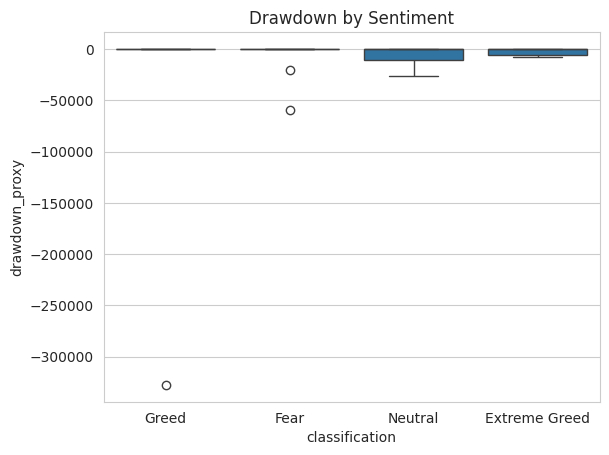

In [136]:
metrics['drawdown_proxy'] = metrics['daily_pnl'].clip(upper=0)

sns.boxplot(
    data=metrics,
    x='classification',
    y='drawdown_proxy'
)
plt.title("Drawdown by Sentiment")
plt.show()

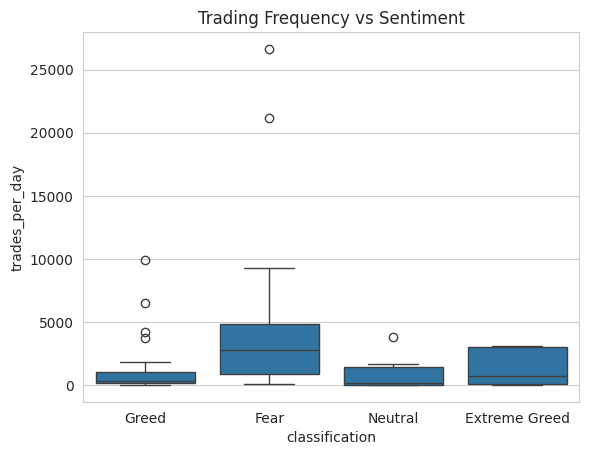

In [137]:
sns.boxplot(
    data=metrics,
    x='classification',
    y='trades_per_day'
)
plt.title("Trading Frequency vs Sentiment")
plt.show()

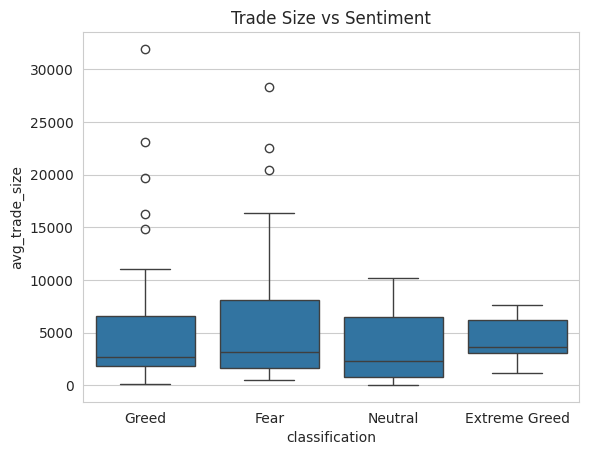

In [138]:
sns.boxplot(
    data=metrics,
    x='classification',
    y='avg_trade_size'
)
plt.title("Trade Size vs Sentiment")
plt.show()

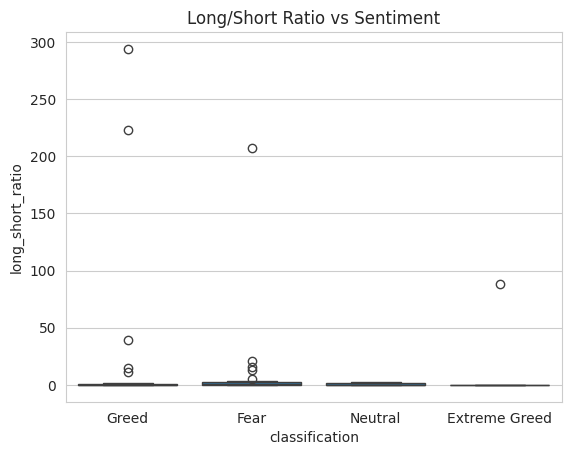

In [139]:
sns.boxplot(
    data=metrics,
    x='classification',
    y='long_short_ratio'
)
plt.title("Long/Short Ratio vs Sentiment")
plt.show()

In [142]:
df['leverage_proxy'] = (
    df['Size USD'].abs() /
    (df['Start Position'].abs() + 1e-6)
)

In [143]:
df[['Size USD','Start Position','leverage_proxy']].head()

,Size USD,Start Position,leverage_proxy
0,7872.16,0.000000,7.872160e+09
1,127.68,986.524596,1.294240e-01
2,1150.63,1002.518996,1.147739e+00
3,1142.04,1146.558564,9.960590e-01
4,69.75,1289.488521,5.409121e-02


In [144]:
lev = df.groupby('Account')['leverage_proxy'].mean()

lev_seg = pd.DataFrame({
    'Account': lev.index,
    'leverage_segment':
        np.where(lev > lev.median(), 'High','Low')
})

In [145]:
freq = metrics.groupby('Account')['trades_per_day'].mean()

freq_seg = pd.DataFrame({
    'Account': freq.index,
    'frequency_segment':
        np.where(freq > freq.median(),
                 'Frequent','Infrequent')
})

In [146]:
consistency = metrics.groupby('Account')['win_rate'].mean()

winner_seg = pd.DataFrame({
    'Account': consistency.index,
    'winner_type':
        np.where(consistency>0.5,
                 'Consistent','Inconsistent')
})

In [147]:
segments = lev_seg.merge(freq_seg,on='Account')\
                  .merge(winner_seg,on='Account')

In [148]:
metrics.merge(segments,on='Account')\
       .groupby('leverage_segment')['daily_pnl'].mean()

,daily_pnl
leverage_segment,
High,144016.008984
Low,62670.194670


PART C

In [150]:
comparison.loc[
    ['daily_pnl','win_rate','trades_per_day','avg_trade_size']
]

,Fear,Greed
daily_pnl,209372.662205,99675.516731
win_rate,0.415878,0.374074
trades_per_day,4183.468750,1134.031250
avg_trade_size,5926.522723,5839.310974


In [152]:
fear_stats = metrics[metrics['classification']=="Fear"].mean(numeric_only=True)
greed_stats = metrics[metrics['classification']=="Greed"].mean(numeric_only=True)

comparison = pd.DataFrame({
    "Fear": fear_stats,
    "Greed": greed_stats
})

comparison[['daily_pnl','win_rate',
            'trades_per_day','avg_trade_size']]

KeyError: "None of [Index(['daily_pnl', 'win_rate', 'trades_per_day', 'avg_trade_size'], dtype='object')] are in the [columns]"

In [153]:
fear_stats = metrics[metrics['classification']=="Fear"].mean(numeric_only=True)
greed_stats = metrics[metrics['classification']=="Greed"].mean(numeric_only=True)

comparison = pd.DataFrame({
    "Fear": fear_stats,
    "Greed": greed_stats
})

comparison.loc[
    ['daily_pnl','win_rate','trades_per_day','avg_trade_size']
]

,Fear,Greed
daily_pnl,209372.662205,99675.516731
win_rate,0.415878,0.374074
trades_per_day,4183.468750,1134.031250
avg_trade_size,5926.522723,5839.310974


OPTIONAL (BONUS)

In [156]:
# sort properly
metrics = metrics.sort_values(['Account','date'])

# next-day pnl
metrics['next_day_pnl'] = metrics.groupby('Account')['daily_pnl'].shift(-1)

In [157]:
metrics['profit_bucket'] = pd.qcut(
    metrics['next_day_pnl'],
    q=3,
    labels=['Low','Medium','High']
)

In [158]:
features = metrics[[
    'win_rate',
    'avg_trade_size',
    'trades_per_day',
    'long_short_ratio',
    'value'
]].fillna(0)

target = metrics['profit_bucket']

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42
)

In [162]:
metrics = metrics.sort_values(['Account','date'])

metrics['next_day_pnl'] = (
    metrics.groupby('Account')['daily_pnl'].shift(-1)
)

In [163]:
metrics['profit_bucket'] = pd.qcut(
    metrics['next_day_pnl'],
    q=3,
    labels=['Low','Medium','High']
)

In [164]:
model_df = metrics.dropna(subset=[
    'profit_bucket',
    'win_rate',
    'avg_trade_size',
    'trades_per_day',
    'long_short_ratio',
    'value'
])

In [165]:
X = model_df[[
    'win_rate',
    'avg_trade_size',
    'trades_per_day',
    'long_short_ratio',
    'value'
]]

y = model_df['profit_bucket']

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ---------- prepare clean modeling dataframe ----------
model_df = metrics.dropna(subset=[
    'profit_bucket',
    'win_rate',
    'avg_trade_size',
    'trades_per_day',
    'long_short_ratio',
    'value'
])

# features
X = model_df[[
    'win_rate',
    'avg_trade_size',
    'trades_per_day',
    'long_short_ratio',
    'value'
]]

# target
y = model_df['profit_bucket']

# ---------- split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# ---------- train ----------
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

print("✅ Model trained successfully")

✅ Model trained successfully


In [170]:
pred = model.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        High       0.60      1.00      0.75         3
         Low       1.00      0.14      0.25         7
      Medium       0.25      0.50      0.33         4

    accuracy                           0.43        14
   macro avg       0.62      0.55      0.44        14
weighted avg       0.70      0.43      0.38        14

